In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi
from tqdm import tqdm
import pandas as pd

from config import get_dates, return_delay_split
from GDa.util import average_stages

In [3]:
s_id = "141024"
tt = 1
br = 1
q = 0.9
at = "cue"
monkey = "lucy"


stages = {}
stages["lucy"] = [[-0.6, -0.3], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stages["ethyl"] = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

sessions = get_dates(monkey)

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda")

In [5]:
# Load power
_FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
power = xr.load_dataarray(path_pow)
attrs = power.attrs
power = power.sel(times=slice(-.5, 1.5))

In [6]:
degree = xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            s_id,
            "session01",
            "network",
            "pec_degree_at_cue.nc",
        )
    )

core = xr.load_dataarray(
        os.path.join(
            os.path.expanduser("~/funcog/gda/Results/lucy"),
            s_id,
            "session01",
            "network",
            "pec_coreness_at_cue.nc",
        )
    )

In [7]:
power_avg = []
for ti, tf in stages[monkey]:
    power_avg += [power.sel(times=slice(ti, tf)).mean("times")]
power = xr.concat(power_avg, "times")


degree_avg = []
for ti, tf in stages[monkey]:
    degree_avg += [degree.sel(times=slice(ti, tf)).mean("times")]
degree = xr.concat(degree_avg, "times")

core_avg = []
for ti, tf in stages[monkey]:
    core_avg += [core.sel(times=slice(ti, tf)).mean("times")]
core = xr.concat(core_avg, "times")

In [8]:
print(power.shape)
print(degree.shape)
print(core.shape)

(5, 582, 105, 10)
(5, 582, 105, 10)
(5, 582, 105, 10)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [11]:
bands = {
    "theta": [0, 3],
    "alpha": [6, 14],
    "beta": [14, 26],
    "high_beta": [26, 43],
    "gamma": [43, 80],
}


def compute_cv_scores(x_train, y_train):

    max_depths = np.arange(1, 21, 1, dtype=int)
    n_estimators = [100, 200, 500]
    max_features = ["sqrt", x_train.shape[1]]

    parameters = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "ccp_alpha": [0, 0.001, 0.01, 0.1],
    }

    est = RandomForestClassifier(n_jobs=20, bootstrap=True)

    clf = GridSearchCV(
        estimator=est,
        param_grid=parameters,
        cv=5,
        scoring="accuracy",
        n_jobs=20,
        return_train_score=True,
        verbose=0,
    )

    clf.fit(x_train, y_train)

    est = RandomForestClassifier(
        **clf.best_params_,
        n_jobs=-1,
    )

    return est


def prepare_data(y, freq, time):

    X = np.stack([degree.sel(freqs=freq, roi="V1").isel(times=time).groupby("roi").mean("roi"),
                power.sel(freqs=freq, roi="V1").isel(times=time).groupby("roi").mean("roi")], axis=1).squeeze()

    X = pd.DataFrame(X, columns=["degree", "power"])


    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, shuffle=True
    )

    return x_train, x_test, y_train, y_test

In [12]:
band = "high_beta"
decoders = []

for time in tqdm(range(degree.sizes["times"])):
    x_train, x_test, y_train, y_test = prepare_data(attrs["stim"], 27, time)
    decoders += [compute_cv_scores(x_train, y_train)]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.65s/it]


In [13]:
cvs = [
    cross_val_score(decoders[t], x_test, y_test, n_jobs=20, cv=5, verbose=0)
    for t in tqdm(range(degree.sizes["times"]))
]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


In [14]:
cvs_surr = []
y_test_sh = y_test.copy()
for i in tqdm(range(100)):
    np.random.shuffle(y_test_sh)
    cvs_surr += [
        [
            cross_val_score(decoders[t], x_test, y_test_sh, n_jobs=20, cv=5, verbose=0)
            for t in range(5)
        ]
    ]

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


In [15]:
cvs = xr.DataArray(np.stack(cvs, 0), dims=("times", "k"))

In [16]:
cvs_surr = xr.DataArray(np.stack(cvs_surr, 0), dims=("boot", "times", "k"))

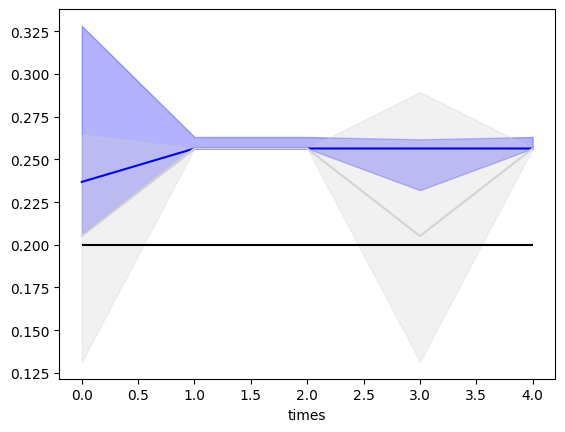

In [21]:
cvs.median("k").plot(color="b")
plt.fill_between(
    range(5),
    np.quantile(cvs, 0.05, 1),
    np.quantile(cvs, 0.95,1),
    color="b",
    alpha=0.3,
)

#cvs_surr = cvs_surr.median("k")
cvs_surr.median("boot").plot(color="lightgray")
plt.fill_between(
    range(5),
    np.quantile(cvs_surr, 0.05, 0),
    np.quantile(cvs_surr, 0.95, 0),
    color="lightgray",
    alpha=0.3,
)
plt.hlines(1/5, 0, 4, "black")

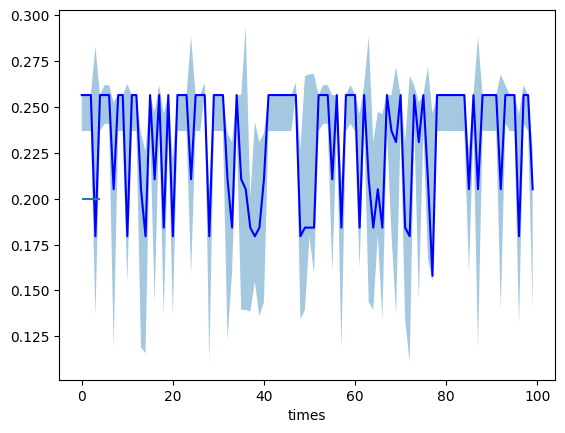

In [55]:

cvs.median("k").plot(color="b")
plt.fill_between(
    cvs.times,
    cvs.quantile(0.05, "k"),
    cvs.quantile(0.95, "k"), alpha=.4
)
cvs.median("k").plot(color="b")

plt.hlines(1/5, 0, 4)

In [8]:
times = [[-0.6, -0.4], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]

cv_scores = []

for time in tqdm(range(5)):
    cv_scores += [compute_cv_scores(time, "high_beta")]

100%|██████████| 5/5 [09:17<00:00, 111.44s/it]


In [9]:
cv_scores_surr = []

for time in tqdm(range(5)):
    cv_scores_surr += [compute_cv_scores(time, "high_beta", shuffle=True)]

100%|██████████| 5/5 [08:30<00:00, 102.01s/it]


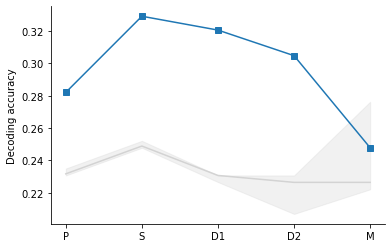

In [11]:
ax = plt.subplot(111)
plt.plot(range(5), np.median(cv_scores, -1), "s-")

plt.plot(range(5), np.median(cv_scores_surr, -1), "lightgray")
plt.fill_between(
    range(5),
    np.quantile(cv_scores_surr, 0.05, -1),
    np.quantile(cv_scores_surr, 0.95, -1),
    color="lightgray",
    alpha=0.3,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("Decoding accuracy")
plt.xticks(range(5), ["P", "S", "D1", "D2", "M"]);

In [30]:
cv = []
cv_surr = []
for session in sessions[:55]:
    cv += [
        xr.load_dataarray(
            f"~/funcog/gda/Results/lucy/decoding/crackles/cv_crackle_high_beta_{session}.nc"
        )
    ]
    cv_surr += [
        xr.load_dataarray(
            f"~/funcog/gda/Results/lucy/decoding/crackles/cv_surr_crackle_high_beta_{session}.nc"
        )
    ]

In [31]:
from frites.stats import confidence_interval

cv = confidence_interval(xr.concat(cv, "k"), axis=1).squeeze()
cv_surr = confidence_interval(xr.concat(cv_surr, "k"), axis=1).squeeze()

    Estimating CI (cis=[95], axis=1, n_boots=200, skipna=True, random_state=None)
    Estimating CI (cis=[95], axis=1, n_boots=200, skipna=True, random_state=None)


Text(0.5, 0, '')

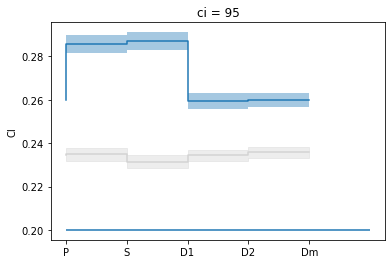

In [33]:
cv.median("bound").plot.step(x="times")
plt.fill_between(
    cv.times, cv.sel(bound="low"), cv.sel(bound="high"), alpha=0.4, step="pre"
)
cv_surr.median("bound").plot.step(x="times", color="lightgray")
plt.fill_between(
    cv_surr.times,
    cv_surr.sel(bound="low"),
    cv_surr.sel(bound="high"),
    color="lightgray",
    alpha=0.4,
    step="pre",
)
plt.hlines(1 / 5, 0, 5)
plt.xticks(range(5), stage_labels)
plt.xlabel("")

In [23]:
f_0, f_1 = bands[band][0], bands[band][1]

X = out.sel(freqs=slice(f_0, f_1), times=2).stack(z=("freqs", "trials"))

In [25]:
unique_rois, n_each = np.unique(X.roi.data, return_counts=True)

<xarray.DataArray (times: 5, k: 5)>
array([[0.25213675, 0.29059829, 0.25641026, 0.29487179, 0.27896996],
       [0.34615385, 0.3974359 , 0.31196581, 0.32051282, 0.30042918],
       [0.38034188, 0.29487179, 0.26495726, 0.32051282, 0.27038627],
       [0.26068376, 0.2991453 , 0.25213675, 0.25641026, 0.27467811],
       [0.21794872, 0.23076923, 0.24358974, 0.21367521, 0.29613734]])
Dimensions without coordinates: times, k

In [41]:
compute_cv_scores(time, "high_beta")

array([0.28632479, 0.23504274, 0.21367521, 0.21794872, 0.26609442])